In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy import sparse
import re
import numpy as np
import math
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier

from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
import os
import joblib
import wordninja
import spacy
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import glob


In [2]:
nltk.download('punkt')                         
nltk.download('stopwords')                     
nltk.download('wordnet')                       
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
def load_reddit_dataset(data_path, s_size=None, text_column="selftext", label_column="subreddit"):

    csv_files = glob.glob(os.path.join(data_path, "**", "*.csv"), recursive=True)
    print(f"Found {len(csv_files)} CSV files.")

    all_dataframes = []
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            all_dataframes.append(df)
        except Exception as e:
            print(f"Error reading {file}: {e}")

    all_data = pd.concat(all_dataframes, ignore_index=True)
    print("Total rows before cleaning:", len(all_data))

    clear_data = all_data.dropna(subset=[text_column, label_column])
    print("Total rows after dropping NA:", len(clear_data))

    if s_size is not None:
        grouped = clear_data.groupby(label_column)
        eligible_groups = [name for name, group in grouped if len(group) >= s_size]
        filtered_data = clear_data[clear_data[label_column].isin(eligible_groups)]
        df_sampled = filtered_data.groupby(label_column).sample(n=s_size, random_state=42)
        df_sampled = df_sampled.reset_index(drop=True)
        print("Sampled class distribution:")
        print(df_sampled[label_column].value_counts())
    else:
        df_sampled = clear_data
        print("Returned all available data without sampling.")
        print(df_sampled[label_column].value_counts())

    return df_sampled[text_column], df_sampled[label_column]

In [4]:
text_data, label_data = load_reddit_dataset("dataset",s_size=100)


Found 223 CSV files.
Total rows before cleaning: 1852403
Total rows after dropping NA: 1797816
Sampled class distribution:
subreddit
Anxiety         100
SuicideWatch    100
depression      100
lonely          100
mentalhealth    100
Name: count, dtype: int64


In [5]:
print(text_data.iloc[0])


A few weeks ago, I finally caved and called my doctor to get back on my anxiety medicine after my anxiety got so bad that I was having panic attacks whenever I left the house. I cried picking it up. I was so ready to feel normal again. 

Well last night I went to the store and felt an anxiety attack coming. Instead of spiraling out of control like I have been, I was easily able to calm down. I can't share this with anyone else so I thought to post it here. I am so happy that I was able to finish shopping and that I didn't end up with a panic attack. 

I don't know why I waited so long to go back on my medicine.


In [6]:
def clean_data(data):
    html_regex = re.compile("<.*?>")
    num_regex = re.compile("\d+")
    pun_re = re.compile("[^\w\s]")

    cleaned_data = []

    for text in data:
        text = re.sub(html_regex, '', text)

        urls = re.findall(r'https?://\S+|www\.\S+', text)
        for url in urls:
            tokens = re.findall(r'[a-zA-Z]{4,}', url)
            if len(tokens) >= 3:
                text = text.replace(url, ' '.join(tokens))
            else:
                text = text.replace(url, '[URL]')

        text = re.sub(num_regex, '', text)

        text = re.sub(pun_re, '', text)

        cleaned_data.append(text)

    return cleaned_data



text_data01 = clean_data(text_data)

text_data01[0]

'A few weeks ago I finally caved and called my doctor to get back on my anxiety medicine after my anxiety got so bad that I was having panic attacks whenever I left the house I cried picking it up I was so ready to feel normal again \n\nWell last night I went to the store and felt an anxiety attack coming Instead of spiraling out of control like I have been I was easily able to calm down I cant share this with anyone else so I thought to post it here I am so happy that I was able to finish shopping and that I didnt end up with a panic attack \n\nI dont know why I waited so long to go back on my medicine'

In [7]:
import language_tool_python

tool = language_tool_python.LanguageTool('en-US')

def correct_text_languagetool(text):
    matches = tool.check(text)
    corrected_text = language_tool_python.utils.correct(text, matches)
    return corrected_text

def correct_texts_languagetool(text_list):
    corrected_texts = []
    for text in text_list:
        corrected_text = correct_text_languagetool(text)
        corrected_texts.append(corrected_text)
    return corrected_texts

text_data_corrected = correct_texts_languagetool(text_data01)

print(text_data_corrected[0])

A few weeks ago I finally caved and called my doctor to get back on my anxiety medicine after my anxiety got so bad that I was having panic attacks whenever I left the house I cried picking it up I was so ready to feel normal again 

Well last night I went to the store and felt an anxiety attack coming Instead of spiraling out of control like I have been I was easily able to calm down I can't share this with anyone else, so I thought to post it here I am so happy that I was able to finish shopping and that I didn't end up with a panic attack 

I don't know why I waited so long to go back on my medicine


In [8]:
def splited_data(data):
    temp_data = []
    for corpus in data:
        words = " ".join(corpus.split()).split()
        fixed_words = []

        for word in words:
            if len(word) > 30:
                split_words = wordninja.split(word)
                fixed_words.extend(split_words)
            else:
                fixed_words.append(word)

        temp_data.append(fixed_words)

    return temp_data



text_data02 = splited_data(text_data_corrected)

text_data02[0]

['A',
 'few',
 'weeks',
 'ago',
 'I',
 'finally',
 'caved',
 'and',
 'called',
 'my',
 'doctor',
 'to',
 'get',
 'back',
 'on',
 'my',
 'anxiety',
 'medicine',
 'after',
 'my',
 'anxiety',
 'got',
 'so',
 'bad',
 'that',
 'I',
 'was',
 'having',
 'panic',
 'attacks',
 'whenever',
 'I',
 'left',
 'the',
 'house',
 'I',
 'cried',
 'picking',
 'it',
 'up',
 'I',
 'was',
 'so',
 'ready',
 'to',
 'feel',
 'normal',
 'again',
 'Well',
 'last',
 'night',
 'I',
 'went',
 'to',
 'the',
 'store',
 'and',
 'felt',
 'an',
 'anxiety',
 'attack',
 'coming',
 'Instead',
 'of',
 'spiraling',
 'out',
 'of',
 'control',
 'like',
 'I',
 'have',
 'been',
 'I',
 'was',
 'easily',
 'able',
 'to',
 'calm',
 'down',
 'I',
 "can't",
 'share',
 'this',
 'with',
 'anyone',
 'else,',
 'so',
 'I',
 'thought',
 'to',
 'post',
 'it',
 'here',
 'I',
 'am',
 'so',
 'happy',
 'that',
 'I',
 'was',
 'able',
 'to',
 'finish',
 'shopping',
 'and',
 'that',
 'I',
 "didn't",
 'end',
 'up',
 'with',
 'a',
 'panic',
 'attack'

In [9]:
def lowercase(data):
    data_lowercase = []

    for corpus in data:
        temp_list = []
        for word in corpus:
            temp = word.lower()
            temp_list.append(temp)

        data_lowercase.append(temp_list)

    return data_lowercase

text_data03 = lowercase(text_data02)


text_data03[0]

['a',
 'few',
 'weeks',
 'ago',
 'i',
 'finally',
 'caved',
 'and',
 'called',
 'my',
 'doctor',
 'to',
 'get',
 'back',
 'on',
 'my',
 'anxiety',
 'medicine',
 'after',
 'my',
 'anxiety',
 'got',
 'so',
 'bad',
 'that',
 'i',
 'was',
 'having',
 'panic',
 'attacks',
 'whenever',
 'i',
 'left',
 'the',
 'house',
 'i',
 'cried',
 'picking',
 'it',
 'up',
 'i',
 'was',
 'so',
 'ready',
 'to',
 'feel',
 'normal',
 'again',
 'well',
 'last',
 'night',
 'i',
 'went',
 'to',
 'the',
 'store',
 'and',
 'felt',
 'an',
 'anxiety',
 'attack',
 'coming',
 'instead',
 'of',
 'spiraling',
 'out',
 'of',
 'control',
 'like',
 'i',
 'have',
 'been',
 'i',
 'was',
 'easily',
 'able',
 'to',
 'calm',
 'down',
 'i',
 "can't",
 'share',
 'this',
 'with',
 'anyone',
 'else,',
 'so',
 'i',
 'thought',
 'to',
 'post',
 'it',
 'here',
 'i',
 'am',
 'so',
 'happy',
 'that',
 'i',
 'was',
 'able',
 'to',
 'finish',
 'shopping',
 'and',
 'that',
 'i',
 "didn't",
 'end',
 'up',
 'with',
 'a',
 'panic',
 'attack'

In [10]:
def remove_stopwords(data):

    res_data = []
    for corpus in data:
        temp_list=[]
        for word in corpus:
            if word not in stopwords.words("english") :
                temp_list.append(word)

        res_data.append(temp_list)

    return res_data
text_data04 = remove_stopwords(text_data03)



text_data04[0]

['weeks',
 'ago',
 'finally',
 'caved',
 'called',
 'doctor',
 'get',
 'back',
 'anxiety',
 'medicine',
 'anxiety',
 'got',
 'bad',
 'panic',
 'attacks',
 'whenever',
 'left',
 'house',
 'cried',
 'picking',
 'ready',
 'feel',
 'normal',
 'well',
 'last',
 'night',
 'went',
 'store',
 'felt',
 'anxiety',
 'attack',
 'coming',
 'instead',
 'spiraling',
 'control',
 'like',
 'easily',
 'able',
 'calm',
 "can't",
 'share',
 'anyone',
 'else,',
 'thought',
 'post',
 'happy',
 'able',
 'finish',
 'shopping',
 'end',
 'panic',
 'attack',
 'know',
 'waited',
 'long',
 'go',
 'back',
 'medicine']

In [11]:
nlp = spacy.load("en_core_web_sm")

def pos_spacy(data):
  
    pos_list = []
    for tokens in data:
        doc = nlp(" ".join(tokens))
        pos_tags = [(token.text, token.pos_) for token in doc]
        pos_list.append(pos_tags)
    return pos_list


text_data06 = pos_spacy(text_data04)


In [12]:
text_data06[0]

[('weeks', 'NOUN'),
 ('ago', 'ADV'),
 ('finally', 'ADV'),
 ('caved', 'VERB'),
 ('called', 'VERB'),
 ('doctor', 'NOUN'),
 ('get', 'VERB'),
 ('back', 'ADV'),
 ('anxiety', 'NOUN'),
 ('medicine', 'NOUN'),
 ('anxiety', 'NOUN'),
 ('got', 'VERB'),
 ('bad', 'ADJ'),
 ('panic', 'NOUN'),
 ('attacks', 'NOUN'),
 ('whenever', 'SCONJ'),
 ('left', 'ADJ'),
 ('house', 'PROPN'),
 ('cried', 'VERB'),
 ('picking', 'VERB'),
 ('ready', 'ADJ'),
 ('feel', 'VERB'),
 ('normal', 'ADJ'),
 ('well', 'ADV'),
 ('last', 'ADJ'),
 ('night', 'NOUN'),
 ('went', 'VERB'),
 ('store', 'NOUN'),
 ('felt', 'VERB'),
 ('anxiety', 'NOUN'),
 ('attack', 'NOUN'),
 ('coming', 'VERB'),
 ('instead', 'ADV'),
 ('spiraling', 'VERB'),
 ('control', 'NOUN'),
 ('like', 'ADP'),
 ('easily', 'ADV'),
 ('able', 'ADJ'),
 ('calm', 'NOUN'),
 ('ca', 'AUX'),
 ("n't", 'PART'),
 ('share', 'VERB'),
 ('anyone', 'PRON'),
 ('else', 'ADV'),
 (',', 'PUNCT'),
 ('thought', 'VERB'),
 ('post', 'VERB'),
 ('happy', 'ADJ'),
 ('able', 'ADJ'),
 ('finish', 'NOUN'),
 ('shopp

In [13]:
def fix_negations(data):
    fixed_data = []
    negation_starters = ['ca', 'do', 'did', 'wo', 'sha', 'is', 'was', 'would', 'could', 'should', 'might', 'must']

    i = 0
    while i < len(data):
        if (i + 1 < len(data) and
            data[i][0].lower() in negation_starters and
            data[i+1][0].lower() == 'nt'):
            
            combined_word = data[i][0] + "n't"
            fixed_data.append((combined_word, data[i][1]))
            i += 2
        else:
            fixed_data.append(data[i])
            i += 1

    return fixed_data

def lemmatizing(data):
    wnl = WordNetLemmatizer()
    lemmatize_data = []

    tag = {
        "NOUN": "n",
        "VERB": "v",
        "ADJ": "a",
        "ADV": "r"
    }

    for corpus in data:
        corpus_fixed = fix_negations(corpus)
        temp_list = []

        for word in corpus_fixed:
            pos_tag = tag.get(word[1], None)
            if pos_tag:
                lemma = wnl.lemmatize(word[0], pos=pos_tag)
            else:
                lemma = word[0]
            temp_list.append(lemma)

        lemmatize_data.append(temp_list)

    return lemmatize_data

text_data07 = lemmatizing(text_data06)

In [14]:
text_data07[0]

['week',
 'ago',
 'finally',
 'cave',
 'call',
 'doctor',
 'get',
 'back',
 'anxiety',
 'medicine',
 'anxiety',
 'get',
 'bad',
 'panic',
 'attack',
 'whenever',
 'left',
 'house',
 'cry',
 'pick',
 'ready',
 'feel',
 'normal',
 'well',
 'last',
 'night',
 'go',
 'store',
 'felt',
 'anxiety',
 'attack',
 'come',
 'instead',
 'spiral',
 'control',
 'like',
 'easily',
 'able',
 'calm',
 'ca',
 "n't",
 'share',
 'anyone',
 'else',
 ',',
 'think',
 'post',
 'happy',
 'able',
 'finish',
 'shopping',
 'end',
 'panic',
 'attack',
 'know',
 'wait',
 'long',
 'go',
 'back',
 'medicine']

In [15]:
# sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  
sbert_model = SentenceTransformer('all-mpnet-base-v2')

def vectorize_sbert(text_data):

    joined_sentences = [" ".join(tokens) for tokens in text_data]
    embeddings = sbert_model.encode(joined_sentences, show_progress_bar=True)
    return embeddings


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\ProgramData\Anaconda3\envs\nlp_env\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [16]:
X_sbert = vectorize_sbert(text_data07)
print("SBERT shape:", X_sbert.shape)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

SBERT shape: (500, 768)


In [17]:
def prepare_data(X, labels, test_size=0.2, random_state=42):

    encoder = LabelEncoder()
    y = encoder.fit_transform(labels)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    return X_train, X_test, y_train, y_test, encoder


In [18]:
X_train_sbert, X_test_sbert, y_train_sbert, y_test_sbert, enc_sbert = prepare_data(X_sbert, label_data)

print("SBERT:", X_train_sbert.shape, X_test_sbert.shape)
print("Label classes:", enc_sbert.classes_)


SBERT: (400, 768) (100, 768)
Label classes: ['Anxiety' 'SuicideWatch' 'depression' 'lonely' 'mentalhealth']


In [19]:
def train_sbert_models(X_train, X_test, y_train, y_test):
    print("🔹 SBERT → Logistic Regression")
    model_lr = LogisticRegression(max_iter=100)
    model_lr.fit(X_train, y_train)
    preds_lr = model_lr.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, preds_lr))
    print(classification_report(y_test, preds_lr))

    print("🔹 SBERT → MLPClassifier")
    model_mlp = MLPClassifier(hidden_layer_sizes=(128,), max_iter=500, random_state=42)
    model_mlp.fit(X_train, y_train)
    preds_mlp = model_mlp.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, preds_mlp))
    print(classification_report(y_test, preds_mlp))

    return model_lr, model_mlp   


In [20]:
model_lr_sbert, model_mlp_sbert = train_sbert_models(X_train_sbert, X_test_sbert, y_train_sbert, y_test_sbert)

🔹 SBERT → Logistic Regression
Accuracy: 0.48
              precision    recall  f1-score   support

           0       0.57      0.65      0.60        20
           1       0.44      0.35      0.39        20
           2       0.28      0.35      0.31        20
           3       0.75      0.60      0.67        20
           4       0.45      0.45      0.45        20

    accuracy                           0.48       100
   macro avg       0.50      0.48      0.48       100
weighted avg       0.50      0.48      0.48       100

🔹 SBERT → MLPClassifier
Accuracy: 0.39
              precision    recall  f1-score   support

           0       0.43      0.60      0.50        20
           1       0.54      0.35      0.42        20
           2       0.20      0.30      0.24        20
           3       0.60      0.30      0.40        20
           4       0.42      0.40      0.41        20

    accuracy                           0.39       100
   macro avg       0.44      0.39      0.39    

In [21]:
def evaluate_model(model, X_test, y_test, encoder, model_name="Model"):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"🔍 {model_name} Accuracy:", acc)
    print(classification_report(y_test, preds, target_names=encoder.classes_))

    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [22]:
def save_model(model, model_name, save_dir="saved_models"):
    os.makedirs(save_dir, exist_ok=True)  
    path = os.path.join(save_dir, f"{model_name}.joblib")
    joblib.dump(model, path)
    print(f"✅ Model saved to: {path}")

🔍 SBERT-LogReg Accuracy: 0.48
              precision    recall  f1-score   support

     Anxiety       0.57      0.65      0.60        20
SuicideWatch       0.44      0.35      0.39        20
  depression       0.28      0.35      0.31        20
      lonely       0.75      0.60      0.67        20
mentalhealth       0.45      0.45      0.45        20

    accuracy                           0.48       100
   macro avg       0.50      0.48      0.48       100
weighted avg       0.50      0.48      0.48       100



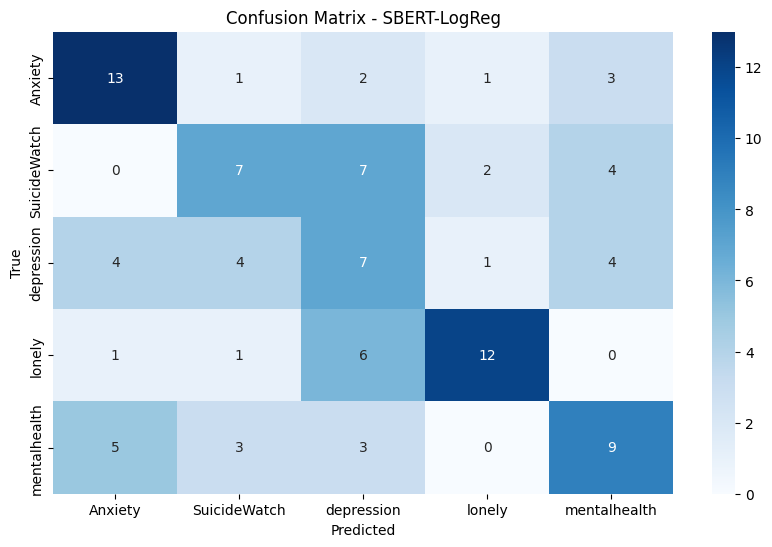

✅ Model saved to: saved_models\SBERT_LogisticRegression.joblib
🔍 SBERT-MLP Accuracy: 0.39
              precision    recall  f1-score   support

     Anxiety       0.43      0.60      0.50        20
SuicideWatch       0.54      0.35      0.42        20
  depression       0.20      0.30      0.24        20
      lonely       0.60      0.30      0.40        20
mentalhealth       0.42      0.40      0.41        20

    accuracy                           0.39       100
   macro avg       0.44      0.39      0.39       100
weighted avg       0.44      0.39      0.39       100



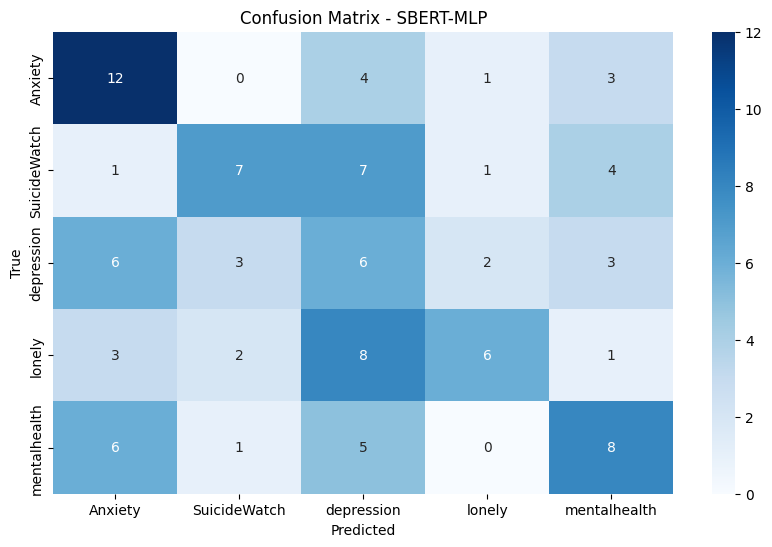

✅ Model saved to: saved_models\SBERT_MLP.joblib


In [23]:
evaluate_model(model_lr_sbert, X_test_sbert, y_test_sbert, enc_sbert, "SBERT-LogReg")
save_model(model_lr_sbert, "SBERT_LogisticRegression")

evaluate_model(model_mlp_sbert, X_test_sbert, y_test_sbert, enc_sbert, "SBERT-MLP")
save_model(model_mlp_sbert, "SBERT_MLP")